### Import libraries

In [23]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import time

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, confusion_matrix

sns.set(style="whitegrid")


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Data Loading and Cleaning

In [25]:
# Load dataset
telco = pd.read_csv("data/telco_customer_churn.csv")

# Drop customerID
telco_cleaned = telco.drop(columns=['customerID'])

# Encode target
telco_cleaned['Churn'] = telco_cleaned['Churn'].map({'Yes':1, 'No':0})

# Identify categorical columns
categorical_cols = [col for col in telco_cleaned.select_dtypes(include=['object']).columns]

# One-hot encode categorical features
telco_encoded = pd.get_dummies(telco_cleaned, columns=categorical_cols, drop_first=True)

# Scale numeric features
numeric_cols = [col for col in telco_encoded.select_dtypes(include=['int64', 'float64']).columns if col != 'Churn']
scaler = StandardScaler()
telco_encoded[numeric_cols] = scaler.fit_transform(telco_encoded[numeric_cols])


### Train-Test Split

In [27]:
X = telco_encoded.drop('Churn', axis=1)
y = telco_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Base Model (Logistic Regression)

=== Logistic Regression ===
Training Time: 1.2619 seconds
Train Accuracy: 0.8761
Test Accuracy: 0.7949
F1-Score: 0.5842
ROC-AUC: 0.8403

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409



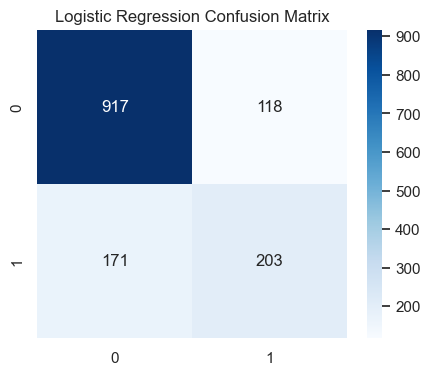

In [28]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    
    train_time = end_time - start_time
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None

    print(f"=== {model_name} ===")
    print(f"Training Time: {train_time:.4f} seconds")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if roc_auc: print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    
    return model

# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model = train_evaluate_model(log_model, X_train, y_train, X_test, y_test, "Logistic Regression")


### Advanced Models

=== Random Forest ===
Training Time: 13.8086 seconds
Train Accuracy: 0.9980
Test Accuracy: 0.7942
F1-Score: 0.5440
ROC-AUC: 0.8298

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1035
           1       0.66      0.46      0.54       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



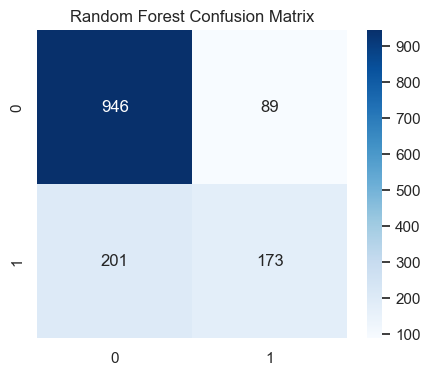

=== Gradient Boosting ===
Training Time: 29.4093 seconds
Train Accuracy: 0.8181
Test Accuracy: 0.7956
F1-Score: 0.5583
ROC-AUC: 0.8457

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.65      0.49      0.56       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.80      0.79      1409



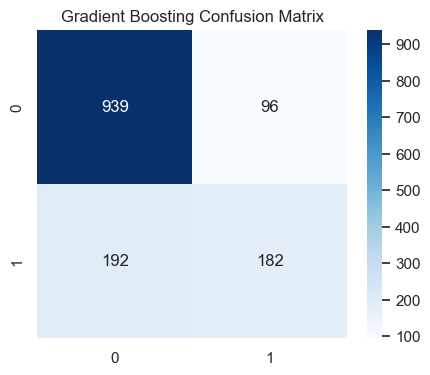

In [30]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model = train_evaluate_model(rf_model, X_train, y_train, X_test, y_test, "Random Forest")

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=200, random_state=42)
gb_model = train_evaluate_model(gb_model, X_train, y_train, X_test, y_test, "Gradient Boosting")


### Feature Importance Visualization

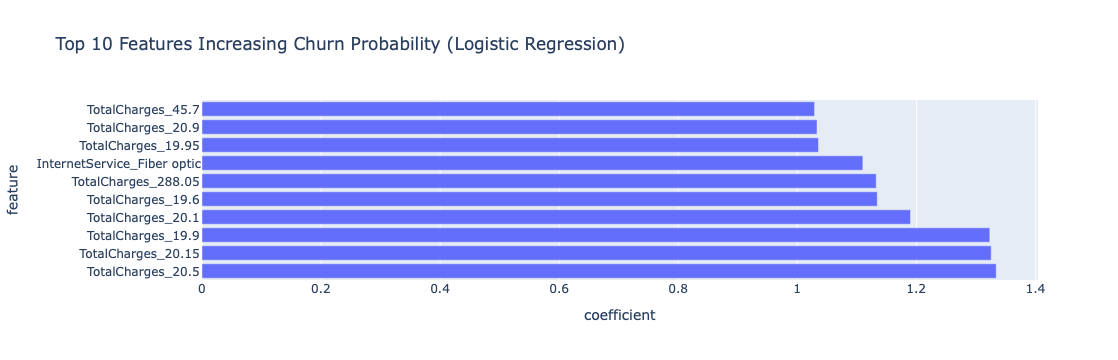

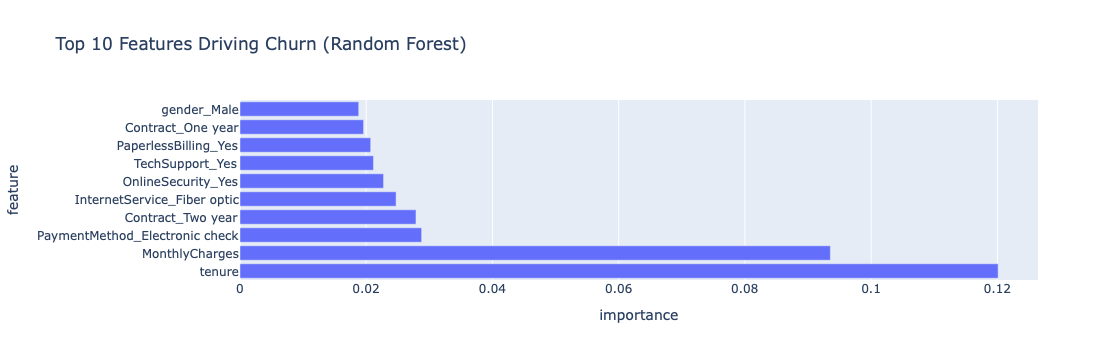

In [33]:
# Logistic Regression coefficients
coefficients = log_model.coef_[0]
feature_importance = pd.DataFrame({'feature':X_train.columns,'coefficient':coefficients}).sort_values(by='coefficient', ascending=False)

fig = px.bar(feature_importance.head(10), x='coefficient', y='feature', orientation='h',
             title="Top 10 Features Increasing Churn Probability (Logistic Regression)")
fig.show()

# Random Forest feature importance
rf_importance = pd.DataFrame({'feature': X_train.columns, 'importance': rf_model.feature_importances_}).sort_values(by='importance', ascending=False)

fig = px.bar(rf_importance.head(10), x='importance', y='feature', orientation='h',
             title="Top 10 Features Driving Churn (Random Forest)")
fig.show()


### Predicted Churn Probability Visualization

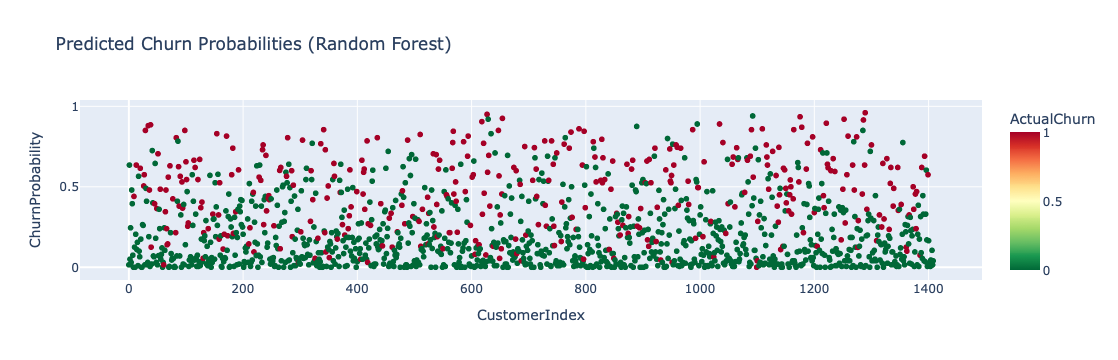

In [34]:
y_proba_rf = rf_model.predict_proba(X_test)[:,1]
prob_df = pd.DataFrame({'CustomerIndex': range(len(y_test)),
                        'ChurnProbability': y_proba_rf,
                        'ActualChurn': y_test.values})

fig = px.scatter(prob_df, x='CustomerIndex', y='ChurnProbability',
                 color='ActualChurn', color_continuous_scale='RdYlGn_r',
                 title='Predicted Churn Probabilities (Random Forest)')
fig.show()


### Model Performance Table

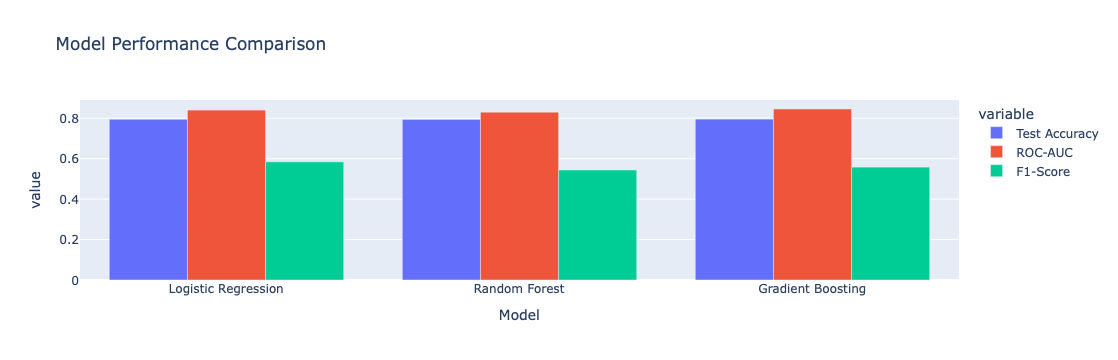

In [36]:
performance_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Train Accuracy': [accuracy_score(y_train, log_model.predict(X_train)),
                       accuracy_score(y_train, rf_model.predict(X_train)),
                       accuracy_score(y_train, gb_model.predict(X_train))],
    'Test Accuracy': [accuracy_score(y_test, log_model.predict(X_test)),
                      accuracy_score(y_test, rf_model.predict(X_test)),
                      accuracy_score(y_test, gb_model.predict(X_test))],
    'ROC-AUC': [roc_auc_score(y_test, log_model.predict_proba(X_test)[:,1]),
                roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]),
                roc_auc_score(y_test, gb_model.predict_proba(X_test)[:,1])],
    'F1-Score': [f1_score(y_test, log_model.predict(X_test)),
                 f1_score(y_test, rf_model.predict(X_test)),
                 f1_score(y_test, gb_model.predict(X_test))]
})

fig = px.bar(performance_summary, x='Model', y=['Test Accuracy','ROC-AUC','F1-Score'], barmode='group',
             title='Model Performance Comparison')
fig.show()


In [37]:
pip install streamlit plotly scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 37.8 MB/s eta 0:00:001m38.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 30.3 MB/s eta 0:00:0031m28.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [streamlit] 10/11 [streamlit]air]]
Note: you may need to restart the kernel to use updated packages.
